In [1]:
#Install Dependencies
import pandas as pd
from pathlib import Path
import re

pd.set_option('display.max_columns',50)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

!pip install openmeteo-requests

!pip install requests-cache retry-requests numpy pandas


import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.utils import resample

from sklearn.model_selection import train_test_split, GridSearchCV
import joblib

In [2]:
#Import CSV's

atlanta_ride_df = pd.read_csv('https://raw.githubusercontent.com/jchay3/james_hay_project_2_Compare_ride_patterns_and_predictive_modeling_of_rides_by-_transport_x/main/Atlanta%20Market%20Rides%20without%20Customer%20Info(1).csv')

In [3]:
#Display the Data
atlanta_ride_df

,ride_id,vehicle_number,ride_type,proximity,driver_name,pickup,radius_schedule_pickup_dispatch_text,pickup_driver_zone,departure,dropoff_driver_zone,ride_start_date_time,ride_end_date_time,customer_mobile,ride_status,allow_start_ride_at,allow_start_ride_description,long_distance_pickup_fee,long_distance_pickup_min_passengers,checkedin_passengers_after_finish_boarding_confirmed_count,age_surge_charge,is_rescan_data_available,total_revenue,ride_miles
0,555847,Fode Soumah,Ride Now,A,Fode Soumah,Midtown,NaN,NaN,729 Brittain Drive Northwest,NaN,03/04/2025 10:23 PM (EST),03/04/2025 10:30 PM (EST),4042858581,Completed,NaN,NaN,0,0,0,0,0,20.64,0.81
1,555751,Fode Soumah,Ride Now,A,Fode Soumah,Midtown,NaN,NaN,North Avenue Apartments,NaN,03/04/2025 08:01 PM (EST),03/04/2025 08:05 PM (EST),6789952504,Completed,NaN,NaN,0,0,0,0,0,16.05,1.19
2,555723,Fode Soumah,Scheduled,A,Fode Soumah,North Avenue Apartments,Radius 1,NaN,Buckhead Fight Club,NaN,03/04/2025 06:42 PM (EST),03/04/2025 06:57 PM (EST),3013370896,Completed,NaN,NaN,0,0,0,0,0,46.80,8.10
3,555626,Fode Soumah,Ride Now,B,Fode Soumah,Home Park,NaN,NaN,955 Spring Street Northwest,NaN,03/03/2025 09:14 PM (EST),03/03/2025 09:21 PM (EST),6178240853,Completed,NaN,NaN,0,0,0,0,0,16.23,1.31
4,555599,Fode Soumah,Ride Now,C,Fode Soumah,Buckhead Fight Club,NaN,NaN,120 North Avenue Northwest,NaN,03/03/2025 08:39 PM (EST),03/03/2025 08:53 PM (EST),4433559115,Completed,NaN,NaN,0,0,0,0,0,52.64,7.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,520226,Fode Soumah,Scheduled,A,Fode Soumah,Clifton Community,Radius 2,NaN,Hudson Grille - Little 5 Points,NaN,02/05/2025 05:53 PM (EST),02/05/2025 06:11 PM (EST),2034612969,Completed,NaN,NaN,0,0,0,0,0,86.66,3.07
185,520093,Fode Soumah,Ride Now,A,Fode Soumah,Clifton Community,NaN,NaN,Smith's Olde Bar,NaN,02/04/2025 11:01 PM (EST),02/04/2025 11:14 PM (EST),6467404455,Completed,NaN,NaN,0,0,0,0,0,48.88,2.87
186,520028,Fode Soumah,Ride Now,B,Fode Soumah,Old Fourth Ward,NaN,NaN,18 Eagle Row,NaN,02/04/2025 10:12 PM (EST),02/04/2025 10:28 PM (EST),6172840818,Completed,NaN,NaN,0,0,0,0,0,39.06,3.98
187,519978,Fode Soumah,Ride Now,B,Fode Soumah,Buckhead,NaN,NaN,Alpha Xi Delta Sorority - Gamma Eta Chapter,NaN,02/04/2025 08:53 PM (EST),02/04/2025 09:06 PM (EST),6789107907,Completed,NaN,NaN,0,0,0,0,0,58.50,2.22


In [4]:
#set up API Client
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [6]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
locations = [
	(30.2672, -97.7431), # Austin, Tx
    (30.4433, -91.1875), # Baton Rouge, LA
    (33.749, -84.388) # Atlanta, GA
]

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 33.749,
	"longitude": -84.388,
	"start_date": "2023-12-31",
	"end_date": "2025-03-01",
	"hourly": ["temperature_2m", "precipitation", "rain", "snowfall", "cloud_cover", "wind_speed_10m"],
	"timezone": "America/Chicago"
}
responses = openmeteo.weather_api(url, params=params)

In [7]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

Coordinates 33.77855682373047°N -84.40298461914062°E
Elevation 327.0 m asl
Timezone b'America/Chicago' b'GMT-5'
Timezone difference to GMT+0 -18000 s


In [8]:
# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
hourly_rain = hourly.Variables(2).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(3).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(5).ValuesAsNumpy()


hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m


atlanta_hourly_dataframe = pd.DataFrame(data = hourly_data)
print(atlanta_hourly_dataframe)

                           date  temperature_2m  precipitation  rain  \
0     2023-12-31 05:00:00+00:00         -0.5035            0.0   0.0   
1     2023-12-31 06:00:00+00:00         -0.7535            0.0   0.0   
2     2023-12-31 07:00:00+00:00         -1.1535            0.0   0.0   
3     2023-12-31 08:00:00+00:00         -1.5535            0.0   0.0   
4     2023-12-31 09:00:00+00:00         -1.6035            0.0   0.0   
...                         ...             ...            ...   ...   
10243 2025-03-02 00:00:00+00:00         12.0965            0.0   0.0   
10244 2025-03-02 01:00:00+00:00         12.1965            0.0   0.0   
10245 2025-03-02 02:00:00+00:00         10.3965            0.0   0.0   
10246 2025-03-02 03:00:00+00:00          7.7465            0.0   0.0   
10247 2025-03-02 04:00:00+00:00          6.0465            0.0   0.0   

       snowfall  cloud_cover  wind_speed_10m  
0           0.0          0.0        7.771331  
1           0.0          0.0        8.049

In [9]:
#Use Regex to remove CST from the orginal Ride Start time
atlanta_ride_df['ride_start_date_time_cleaned'] = atlanta_ride_df['ride_start_date_time'].str.replace(r'\s*\([A-Z]+\)', '', regex=True)
atlanta_ride_df['ride_end_date_time_cleaned'] = atlanta_ride_df['ride_end_date_time'].str.replace(r'\s*\([A-Z]+\)', '', regex=True)

atlanta_ride_df['ride_start_date_time_converted'] = pd.to_datetime(atlanta_ride_df['ride_start_date_time_cleaned'], format='%m/%d/%Y %I:%M %p')
atlanta_ride_df['ride_end_date_time_converted'] = pd.to_datetime(atlanta_ride_df['ride_end_date_time_cleaned'], format='%m/%d/%Y %I:%M %p')

atlanta_ride_df

,ride_id,vehicle_number,ride_type,proximity,driver_name,pickup,radius_schedule_pickup_dispatch_text,pickup_driver_zone,departure,dropoff_driver_zone,ride_start_date_time,ride_end_date_time,customer_mobile,ride_status,allow_start_ride_at,allow_start_ride_description,long_distance_pickup_fee,long_distance_pickup_min_passengers,checkedin_passengers_after_finish_boarding_confirmed_count,age_surge_charge,is_rescan_data_available,total_revenue,ride_miles,ride_start_date_time_cleaned,ride_end_date_time_cleaned,ride_start_date_time_converted,ride_end_date_time_converted
0,555847,Fode Soumah,Ride Now,A,Fode Soumah,Midtown,NaN,NaN,729 Brittain Drive Northwest,NaN,03/04/2025 10:23 PM (EST),03/04/2025 10:30 PM (EST),4042858581,Completed,NaN,NaN,0,0,0,0,0,20.64,0.81,03/04/2025 10:23 PM,03/04/2025 10:30 PM,2025-03-04 22:23:00,2025-03-04 22:30:00
1,555751,Fode Soumah,Ride Now,A,Fode Soumah,Midtown,NaN,NaN,North Avenue Apartments,NaN,03/04/2025 08:01 PM (EST),03/04/2025 08:05 PM (EST),6789952504,Completed,NaN,NaN,0,0,0,0,0,16.05,1.19,03/04/2025 08:01 PM,03/04/2025 08:05 PM,2025-03-04 20:01:00,2025-03-04 20:05:00
2,555723,Fode Soumah,Scheduled,A,Fode Soumah,North Avenue Apartments,Radius 1,NaN,Buckhead Fight Club,NaN,03/04/2025 06:42 PM (EST),03/04/2025 06:57 PM (EST),3013370896,Completed,NaN,NaN,0,0,0,0,0,46.80,8.10,03/04/2025 06:42 PM,03/04/2025 06:57 PM,2025-03-04 18:42:00,2025-03-04 18:57:00
3,555626,Fode Soumah,Ride Now,B,Fode Soumah,Home Park,NaN,NaN,955 Spring Street Northwest,NaN,03/03/2025 09:14 PM (EST),03/03/2025 09:21 PM (EST),6178240853,Completed,NaN,NaN,0,0,0,0,0,16.23,1.31,03/03/2025 09:14 PM,03/03/2025 09:21 PM,2025-03-03 21:14:00,2025-03-03 21:21:00
4,555599,Fode Soumah,Ride Now,C,Fode Soumah,Buckhead Fight Club,NaN,NaN,120 North Avenue Northwest,NaN,03/03/2025 08:39 PM (EST),03/03/2025 08:53 PM (EST),4433559115,Completed,NaN,NaN,0,0,0,0,0,52.64,7.35,03/03/2025 08:39 PM,03/03/2025 08:53 PM,2025-03-03 20:39:00,2025-03-03 20:53:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,520226,Fode Soumah,Scheduled,A,Fode Soumah,Clifton Community,Radius 2,NaN,Hudson Grille - Little 5 Points,NaN,02/05/2025 05:53 PM (EST),02/05/2025 06:11 PM (EST),2034612969,Completed,NaN,NaN,0,0,0,0,0,86.66,3.07,02/05/2025 05:53 PM,02/05/2025 06:11 PM,2025-02-05 17:53:00,2025-02-05 18:11:00
185,520093,Fode Soumah,Ride Now,A,Fode Soumah,Clifton Community,NaN,NaN,Smith's Olde Bar,NaN,02/04/2025 11:01 PM (EST),02/04/2025 11:14 PM (EST),6467404455,Completed,NaN,NaN,0,0,0,0,0,48.88,2.87,02/04/2025 11:01 PM,02/04/2025 11:14 PM,2025-02-04 23:01:00,2025-02-04 23:14:00
186,520028,Fode Soumah,Ride Now,B,Fode Soumah,Old Fourth Ward,NaN,NaN,18 Eagle Row,NaN,02/04/2025 10:12 PM (EST),02/04/2025 10:28 PM (EST),6172840818,Completed,NaN,NaN,0,0,0,0,0,39.06,3.98,02/04/2025 10:12 PM,02/04/2025 10:28 PM,2025-02-04 22:12:00,2025-02-04 22:28:00
187,519978,Fode Soumah,Ride Now,B,Fode Soumah,Buckhead,NaN,NaN,Alpha Xi Delta Sorority - Gamma Eta Chapter,NaN,02/04/2025 08:53 PM (EST),02/04/2025 09:06 PM (EST),6789107907,Completed,NaN,NaN,0,0,0,0,0,58.50,2.22,02/04/2025 08:53 PM,02/04/2025 09:06 PM,2025-02-04 20:53:00,2025-02-04 21:06:00


In [ ]:
#Convert weather time to match converted time of Ride info 

atlanta_hourly_dataframe['date_converted'] = (
    pd.to_datetime(atlanta_hourly_dataframe['date'], format='%m/%d/%Y %I:%M %p')
    .dt.tz_localize(None)
)
atlanta_hourly_dataframe

,date,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,date_converted
0,2023-12-31 05:00:00+00:00,-0.5035,0.0,0.0,0.0,0.0,7.771331,2023-12-31 05:00:00
1,2023-12-31 06:00:00+00:00,-0.7535,0.0,0.0,0.0,0.0,8.049845,2023-12-31 06:00:00
2,2023-12-31 07:00:00+00:00,-1.1535,0.0,0.0,0.0,0.0,6.849467,2023-12-31 07:00:00
3,2023-12-31 08:00:00+00:00,-1.5535,0.0,0.0,0.0,0.0,6.519877,2023-12-31 08:00:00
4,2023-12-31 09:00:00+00:00,-1.6035,0.0,0.0,0.0,14.0,6.877790,2023-12-31 09:00:00
...,...,...,...,...,...,...,...,...
10243,2025-03-02 00:00:00+00:00,12.0965,0.0,0.0,0.0,100.0,15.277749,2025-03-02 00:00:00
10244,2025-03-02 01:00:00+00:00,12.1965,0.0,0.0,0.0,96.0,18.072752,2025-03-02 01:00:00
10245,2025-03-02 02:00:00+00:00,10.3965,0.0,0.0,0.0,93.0,21.252199,2025-03-02 02:00:00
10246,2025-03-02 03:00:00+00:00,7.7465,0.0,0.0,0.0,94.0,20.288164,2025-03-02 03:00:00


In [11]:
# Merge on the ride start time with weather data for that time
atlanta_merged_data = pd.merge_asof(
    atlanta_ride_df.sort_values('ride_start_date_time_converted'), 
    atlanta_hourly_dataframe.sort_values('date_converted'), 
    left_on='ride_start_date_time_converted', 
    right_on='date_converted', 
    direction='backward'  
)

atlanta_merged_data

,ride_id,vehicle_number,ride_type,proximity,driver_name,pickup,radius_schedule_pickup_dispatch_text,pickup_driver_zone,departure,dropoff_driver_zone,ride_start_date_time,ride_end_date_time,customer_mobile,ride_status,allow_start_ride_at,allow_start_ride_description,long_distance_pickup_fee,long_distance_pickup_min_passengers,checkedin_passengers_after_finish_boarding_confirmed_count,age_surge_charge,is_rescan_data_available,total_revenue,ride_miles,ride_start_date_time_cleaned,ride_end_date_time_cleaned,ride_start_date_time_converted,ride_end_date_time_converted,date,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,date_converted
0,519920,Fode Soumah,Ride Now,A,Fode Soumah,Midtown,NaN,NaN,Georgia Tech Campus Recreation Center,NaN,02/04/2025 05:30 PM (EST),02/04/2025 05:49 PM (EST),7702839926,Completed,NaN,NaN,0,0,0,0,0,38.99,1.63,02/04/2025 05:30 PM,02/04/2025 05:49 PM,2025-02-04 17:30:00,2025-02-04 17:49:00,2025-02-04 17:00:00+00:00,19.646500,0.0,0.0,0.0,1.0,11.525623,2025-02-04 17:00:00
1,519978,Fode Soumah,Ride Now,B,Fode Soumah,Buckhead,NaN,NaN,Alpha Xi Delta Sorority - Gamma Eta Chapter,NaN,02/04/2025 08:53 PM (EST),02/04/2025 09:06 PM (EST),6789107907,Completed,NaN,NaN,0,0,0,0,0,58.50,2.22,02/04/2025 08:53 PM,02/04/2025 09:06 PM,2025-02-04 20:53:00,2025-02-04 21:06:00,2025-02-04 20:00:00+00:00,21.796499,0.0,0.0,0.0,0.0,8.748075,2025-02-04 20:00:00
2,520028,Fode Soumah,Ride Now,B,Fode Soumah,Old Fourth Ward,NaN,NaN,18 Eagle Row,NaN,02/04/2025 10:12 PM (EST),02/04/2025 10:28 PM (EST),6172840818,Completed,NaN,NaN,0,0,0,0,0,39.06,3.98,02/04/2025 10:12 PM,02/04/2025 10:28 PM,2025-02-04 22:12:00,2025-02-04 22:28:00,2025-02-04 22:00:00+00:00,21.146500,0.0,0.0,0.0,0.0,5.004518,2025-02-04 22:00:00
3,520093,Fode Soumah,Ride Now,A,Fode Soumah,Clifton Community,NaN,NaN,Smith's Olde Bar,NaN,02/04/2025 11:01 PM (EST),02/04/2025 11:14 PM (EST),6467404455,Completed,NaN,NaN,0,0,0,0,0,48.88,2.87,02/04/2025 11:01 PM,02/04/2025 11:14 PM,2025-02-04 23:01:00,2025-02-04 23:14:00,2025-02-04 23:00:00+00:00,18.546499,0.0,0.0,0.0,0.0,3.964088,2025-02-04 23:00:00
4,520226,Fode Soumah,Scheduled,A,Fode Soumah,Clifton Community,Radius 2,NaN,Hudson Grille - Little 5 Points,NaN,02/05/2025 05:53 PM (EST),02/05/2025 06:11 PM (EST),2034612969,Completed,NaN,NaN,0,0,0,0,0,86.66,3.07,02/05/2025 05:53 PM,02/05/2025 06:11 PM,2025-02-05 17:53:00,2025-02-05 18:11:00,2025-02-05 17:00:00+00:00,20.296499,0.0,0.0,0.0,58.0,4.735060,2025-02-05 17:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,555599,Fode Soumah,Ride Now,C,Fode Soumah,Buckhead Fight Club,NaN,NaN,120 North Avenue Northwest,NaN,03/03/2025 08:39 PM (EST),03/03/2025 08:53 PM (EST),4433559115,Completed,NaN,NaN,0,0,0,0,0,52.64,7.35,03/03/2025 08:39 PM,03/03/2025 08:53 PM,2025-03-03 20:39:00,2025-03-03 20:53:00,2025-03-02 04:00:00+00:00,6.046500,0.0,0.0,0.0,100.0,18.532135,2025-03-02 04:00:00
185,555626,Fode Soumah,Ride Now,B,Fode Soumah,Home Park,NaN,NaN,955 Spring Street Northwest,NaN,03/03/2025 09:14 PM (EST),03/03/2025 09:21 PM (EST),6178240853,Completed,NaN,NaN,0,0,0,0,0,16.23,1.31,03/03/2025 09:14 PM,03/03/2025 09:21 PM,2025-03-03 21:14:00,2025-03-03 21:21:00,2025-03-02 04:00:00+00:00,6.046500,0.0,0.0,0.0,100.0,18.532135,2025-03-02 04:00:00
186,555723,Fode Soumah,Scheduled,A,Fode Soumah,North Avenue Apartments,Radius 1,NaN,Buckhead Fight Club,NaN,03/04/2025 06:42 PM (EST),03/04/2025 06:57 PM (EST),3013370896,Completed,NaN,NaN,0,0,0,0,0,46.80,8.10,03/04/2025 06:42 PM,03/04/2025 06:57 PM,2025-03-04 18:42:00,2025-03-04 18:57:00,2025-03-02 04:00:00+00:00,6.046500,0.0,0.0,0.0,100.0,18.532135,2025-03-02 04:00:00
187,555751,Fode Soumah,Ride Now,A,Fode Soumah,Midtown,NaN,NaN,North Avenue Apartments,NaN,03/04/2025 08:01 PM (EST),03/04/2025 08:05 PM (EST),6789952504,Completed,NaN,NaN,0,0,0,0,0,16.05,1.19,03/04/2025 08:01 PM,03/04/2025 08:05 PM,2025-03-04 20:01:00,2025-03-04 20:05:00,2025-

In [12]:
#Create a funnction that produces a ride time column by figuring out difference between start and end times of rides

def calculate_ride_duration(start_time, end_time):
    return (end_time - start_time).total_seconds() / 60

atlanta_merged_data['total_ride_time_minutes'] = atlanta_merged_data.apply(
    lambda row: calculate_ride_duration(row['ride_start_date_time_converted'], row['ride_end_date_time_converted']), axis=1
)

print(atlanta_merged_data[['ride_start_date_time_converted', 'ride_end_date_time_converted', 'total_ride_time_minutes']].head())

  ride_start_date_time_converted ride_end_date_time_converted  \
0            2025-02-04 17:30:00          2025-02-04 17:49:00   
1            2025-02-04 20:53:00          2025-02-04 21:06:00   
2            2025-02-04 22:12:00          2025-02-04 22:28:00   
3            2025-02-04 23:01:00          2025-02-04 23:14:00   
4            2025-02-05 17:53:00          2025-02-05 18:11:00   

   total_ride_time_minutes  
0                     19.0  
1                     13.0  
2                     16.0  
3                     13.0  
4                     18.0  


In [13]:
#drop unwanted columns and create a cleaned DF

columns_to_drop = [
    'ride_id', 'vehicle_number', 'ride_type', 'proximity', 'driver_name', 'pickup', 
    'radius_schedule_pickup_dispatch_text', 'pickup_driver_zone', 'departure', 
    'dropoff_driver_zone', 'ride_start_date_time', 'ride_end_date_time', 'customer_mobile', 
    'ride_status', 'allow_start_ride_at', 'allow_start_ride_description', 
    'long_distance_pickup_fee', 'long_distance_pickup_min_passengers', 
    'checkedin_passengers_after_finish_boarding_confirmed_count', 
    'is_rescan_data_available', 'ride_end_date_time_cleaned', 
    'ride_start_date_time_cleaned', 'date_converted', 'date', 
]

atlanta_cleaned = atlanta_merged_data.drop(columns=columns_to_drop)

atlanta_cleaned

,age_surge_charge,total_revenue,ride_miles,ride_start_date_time_converted,ride_end_date_time_converted,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,total_ride_time_minutes
0,0,38.99,1.63,2025-02-04 17:30:00,2025-02-04 17:49:00,19.646500,0.0,0.0,0.0,1.0,11.525623,19.0
1,0,58.50,2.22,2025-02-04 20:53:00,2025-02-04 21:06:00,21.796499,0.0,0.0,0.0,0.0,8.748075,13.0
2,0,39.06,3.98,2025-02-04 22:12:00,2025-02-04 22:28:00,21.146500,0.0,0.0,0.0,0.0,5.004518,16.0
3,0,48.88,2.87,2025-02-04 23:01:00,2025-02-04 23:14:00,18.546499,0.0,0.0,0.0,0.0,3.964088,13.0
4,0,86.66,3.07,2025-02-05 17:53:00,2025-02-05 18:11:00,20.296499,0.0,0.0,0.0,58.0,4.735060,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...
184,0,52.64,7.35,2025-03-03 20:39:00,2025-03-03 20:53:00,6.046500,0.0,0.0,0.0,100.0,18.532135,14.0
185,0,16.23,1.31,2025-03-03 21:14:00,2025-03-03 21:21:00,6.046500,0.0,0.0,0.0,100.0,18.532135,7.0
186,0,46.80,8.10,2025-03-04 18:42:00,2025-03-04 18:57:00,6.046500,0.0,0.0,0.0,100.0,18.532135,15.0
187,0,16.05,1.19,2025-03-04 20:01:00,2025-03-04 20:05:00,6.046500,0.0,0.0,0.0,100.0,18.532135,4.0


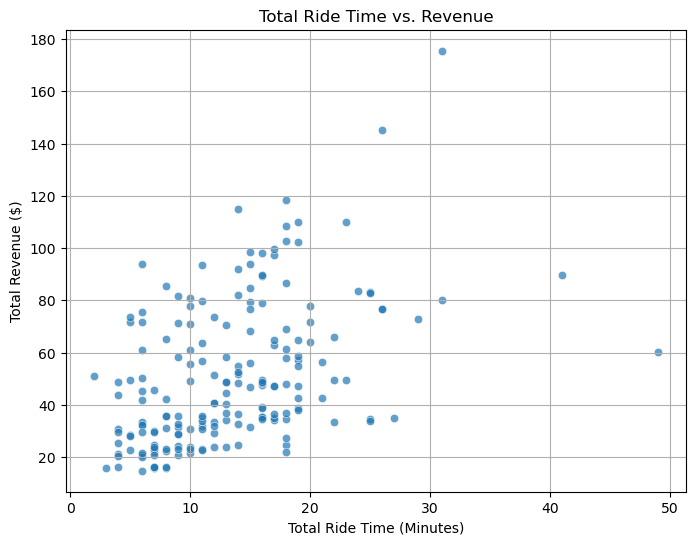

In [14]:
#Create a scatter plot to visualize ride times vs Revenue

plt.figure(figsize=(8, 6))
sns.scatterplot(data=atlanta_cleaned, x='total_ride_time_minutes', y='total_revenue', alpha=0.7)
plt.xlabel('Total Ride Time (Minutes)')
plt.ylabel('Total Revenue ($)')
plt.title('Total Ride Time vs. Revenue')
plt.grid(True)
plt.show()

In [16]:
#Create Hour Columns
atlanta_cleaned['hour'] = atlanta_cleaned['ride_start_date_time_converted'].dt.hour

atlanta_cleaned

,age_surge_charge,total_revenue,ride_miles,ride_start_date_time_converted,ride_end_date_time_converted,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,total_ride_time_minutes,precipitation_category,hour
0,0,38.99,1.63,2025-02-04 17:30:00,2025-02-04 17:49:00,19.646500,0.0,0.0,0.0,1.0,11.525623,19.0,0,17
1,0,58.50,2.22,2025-02-04 20:53:00,2025-02-04 21:06:00,21.796499,0.0,0.0,0.0,0.0,8.748075,13.0,0,20
2,0,39.06,3.98,2025-02-04 22:12:00,2025-02-04 22:28:00,21.146500,0.0,0.0,0.0,0.0,5.004518,16.0,0,22
3,0,48.88,2.87,2025-02-04 23:01:00,2025-02-04 23:14:00,18.546499,0.0,0.0,0.0,0.0,3.964088,13.0,0,23
4,0,86.66,3.07,2025-02-05 17:53:00,2025-02-05 18:11:00,20.296499,0.0,0.0,0.0,58.0,4.735060,18.0,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,0,52.64,7.35,2025-03-03 20:39:00,2025-03-03 20:53:00,6.046500,0.0,0.0,0.0,100.0,18.532135,14.0,0,20
185,0,16.23,1.31,2025-03-03 21:14:00,2025-03-03 21:21:00,6.046500,0.0,0.0,0.0,100.0,18.532135,7.0,0,21
186,0,46.80,8.10,2025-03-04 18:42:00,2025-03-04 18:57:00,6.046500,0.0,0.0,0.0,100.0,18.532135,15.0,0,18
187,0,16.05,1.19,2025-03-04 20:01:00,2025-03-04 20:05:00,6.046500,0.0,0.0,0.0,100.0,18.532135,4.0,0,20


In [17]:
#Create Rush Hour Ride Column

atlanta_cleaned['rush_hour_ride'] = ((atlanta_cleaned['hour'] >= 17) | (atlanta_cleaned['hour'] <= 2))

In [15]:
#Create Precipitation Categories
# Create 'precipitation_category' based on precipitation values
def categorize_precipitation(value):
    if value == 0:
        return 0  # None
    elif 0 < value <= 2:
        return 1  # Light
    elif 2 < value <= 5:
        return 2  # Medium
    else:
        return 3  # Heavy

atlanta_cleaned["precipitation_category"] = atlanta_cleaned["precipitation"].apply(categorize_precipitation)
atlanta_cleaned.value_counts("precipitation_category")

precipitation_category
0    178
1     11
Name: count, dtype: int64

In [18]:
# Convert boolean values to integers (1 = rush hour, 0 = non-rush hour)
atlanta_cleaned['rush_hour_ride'] = atlanta_cleaned['rush_hour_ride'].astype(int)